<a href="https://colab.research.google.com/github/Moorea-AI/ANALITICA3/blob/main/d_modelos2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
################################################################
#               PRIMER TRABAJO PARA LA MATERIA:                #
#                 APLICACIONES DE LA ANALITICA                 #
#                  MÓDULO DE RECURSOS HUMANOS                  #
#                              POR:                            #
#                                                              #
#                    AURA LUZ MORENO - MOOREA                  #
#                       ALEJANDRA AGUIRRE                      #
#                                                              #
#                    UNIVERSIDAD DE ANTIOQUIA                  #
################################################################

In [232]:
###importar librerias
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error, r2_score, classification_report
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import sys
import sqlite3 as sql #### para bases de datos sql
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE

##Importación de datos

In [233]:
sys.path.append('/content/drive/MyDrive')

In [234]:
#conectamos drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
## conectamos las funciones
import a_funciones as funciones

In [236]:
### se genera la URL para conectarse a la base de datos
BD = 'https://raw.githubusercontent.com/Moorea-AI/ANALITICA3/main/databases/BD.csv'

In [237]:
df=pd.read_csv(BD)

In [238]:
df.info() ### mostramos para ver cuales variables son categoricas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35280 entries, 0 to 35279
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employeeid               35280 non-null  int64  
 1   environmentsatisfaction  35280 non-null  float64
 2   jobsatisfaction          35280 non-null  float64
 3   worklifebalance          35280 non-null  float64
 4   datesurvey               35280 non-null  object 
 5   jobinvolvement           35280 non-null  int64  
 6   performancerating        35280 non-null  int64  
 7   surveydate               35280 non-null  object 
 8   attrition                35280 non-null  object 
 9   retirementdate           35280 non-null  object 
 10  retirementtype           35280 non-null  object 
 11  resignationreason        35280 non-null  object 
 12  age                      35280 non-null  int64  
 13  businesstravel           35280 non-null  object 
 14  department            

In [239]:
## se eliminan algunas filas que no son necesarias para la implementación del modelo
df= df.drop(['datesurvey', 'surveydate', 'infodate', 'employeeid', 'retirementdate', 'infodate','retirementdate','retirementtype'],  axis=1)

In [240]:
##crreamos una lista con las variables categoricas
list_dummies = ['resignationreason', 'businesstravel', 'department', 'educationfield', 'gender', 'jobrole', 'maritalstatus']


In [241]:
df_dummies=pd.get_dummies(df,columns=list_dummies)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35280 entries, 0 to 35279
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   environmentsatisfaction            35280 non-null  float64
 1   jobsatisfaction                    35280 non-null  float64
 2   worklifebalance                    35280 non-null  float64
 3   jobinvolvement                     35280 non-null  int64  
 4   performancerating                  35280 non-null  int64  
 5   attrition                          35280 non-null  object 
 6   age                                35280 non-null  int64  
 7   distancefromhome                   35280 non-null  int64  
 8   education                          35280 non-null  int64  
 9   joblevel                           35280 non-null  int64  
 10  monthlyincome                      35280 non-null  int64  
 11  numcompaniesworked                 35280 non-null  flo

In [242]:
print(df_dummies.attrition.unique())


['No' 'Yes']


In [243]:
### debido a la alta correlación que se encontro en el análisis exploratorio se elimina las siguientes variables:
df_d = df_dummies.drop(['age', 'yearsatcompany', 'yearssincelastpromotion'],  axis=1)

In [244]:
###lista con variables numericas
ce=["distancefromhome","education","joblevel","monthlyincome","percentsalaryhike","stockoptionlevel","jobinvolvement"]


In [245]:
### creamos una función que permita normalizar la variable objetivo
def cambiar_si_no_a_numeros(columna):
    return columna.map({'Yes': 1, 'No': 0})

# Supongamos que tienes un DataFrame llamado df y quieres cambiar los valores de la columna 'columna_si_no'
df_d['attrition'] = cambiar_si_no_a_numeros(df_d['attrition'])

In [246]:
y=df_d["attrition"]
x=df_d.drop(["attrition"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

df_d[ce]=df_d[ce].astype(float)
columnasfloat=list(df_d.select_dtypes("float64").columns)
pipeline=ColumnTransformer([("num", StandardScaler(),columnasfloat)],remainder='passthrough')

X_train_std = pipeline.fit_transform(X_train)
X_test_std = pipeline.transform(X_test)

##Modelo base

In [247]:
# Entrenamiento del modelo
modelo = LogisticRegression(max_iter=1000, solver='sag')
# Ajustar el modelo a los datos
modelo.fit(X_train_std, y_train)
# Desempeño en el entrenamiento
y_train_pred = modelo.predict(X_train_std)
print('Exactitud en el entrenamiento: %.3f'  %accuracy_score(y_train, y_train_pred))

Exactitud en el entrenamiento: 0.984


In [248]:
y_pred = modelo.predict(X_test_std)
# Exactitud en el conjunto de validación
print('Exactitud en la validacion: %.3f'  %accuracy_score(y_test, y_pred))

Exactitud en la validacion: 0.985


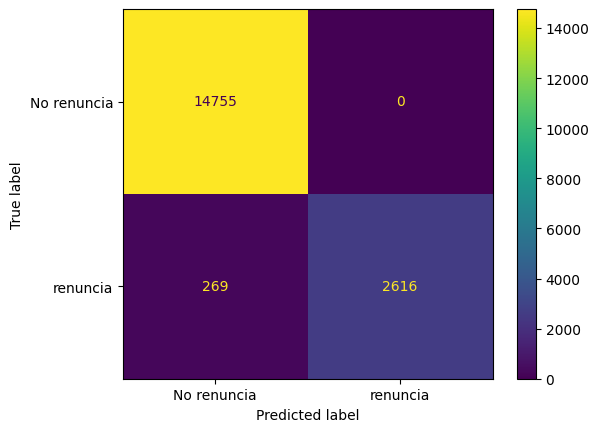

In [249]:
matriz= confusion_matrix(y_test, y_pred)
matriz_display = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['No renuncia', 'renuncia'])
matriz_display.plot()
plt.show()


In [250]:
tn, fp, fn, tp = matriz.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
especificidad = tn / (fp + tn)
f1_score = 2*(precision*recall)/(precision+recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Especificidad: {especificidad}')
print(f'F1 score: {f1_score}')

Precision: 1.0
Recall: 0.9067590987868285
Especificidad: 1.0
F1 score: 0.951099800036357


#Con balanceo de clases

In [251]:
from sklearn.metrics import accuracy_score
X_train_std1=X_train_std.copy()
X_test_std1=X_test_std.copy()
# Entrenamiento del modelo
modelo1 = LogisticRegression(class_weight="balanced",random_state=142)

# Ajustar el modelo a los datos
modelo1.fit(X_train_std1, y_train)

# Desempeño en el entrenamiento
y_train_pred1 = modelo1.predict(X_train_std1)

print('Exactitud en el entrenamiento: %.3f'  %accuracy_score(y_train, y_train_pred1) )

Exactitud en el entrenamiento: 0.984


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [252]:
y_pred1 = modelo1.predict(X_test_std1)

# Exactitud en el conjunto de validación
print('Exactitud en el validacion: %.3f'  %accuracy_score(y_test, y_pred1))

Exactitud en el validacion: 0.985


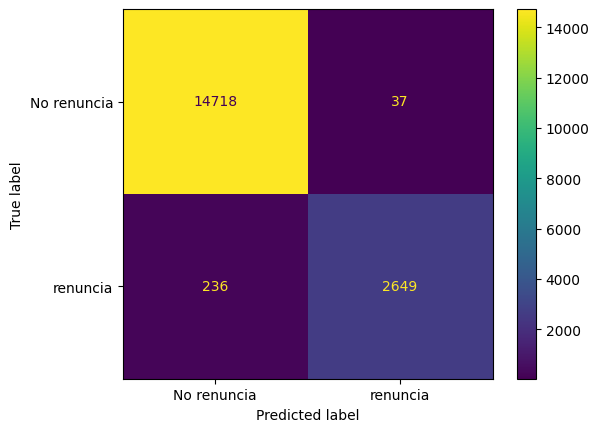

In [253]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz1= confusion_matrix(y_test, y_pred1)
matriz_display1 = ConfusionMatrixDisplay(confusion_matrix=matriz1, display_labels=['No renuncia', 'renuncia'])
matriz_display1.plot()
plt.show()

##Balanceo de clases manual

In [254]:
###metricas de desempeño
tn, fp, fn, tp = matriz1.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
especificidad = tn / (fp + tn)
f1_score = 2*(precision*recall)/(precision+recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Especificidad: {especificidad}')
print(f'F1 score: {f1_score}')

Precision: 0.9862248696947133
Recall: 0.9181975736568457
Especificidad: 0.9974923754659437
F1 score: 0.9509962304792676


In [255]:
os_us = SMOTETomek()
x_train_res, y_train_res = os_us.fit_resample(X_train_std, y_train)

print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 14837, 1: 2803})
Distribution after resampling Counter({0: 14837, 1: 14837})


Selección de varianbles con el metódo Lasso

In [256]:
sel_ = SelectFromModel(Lasso(alpha = 0.001, max_iter=10000), max_features=30) #entre mas aumente el parametro de serializacion, mas variables van atender a 0
sel_.fit(X_train_std, y_train)
print(sel_.estimator_.coef_)
#Obtener variables seleccionadas
X_new = sel_.get_support()#descarta los coeficientes mas cercanos a 0
X_train_base1 = X_train_std[:,X_new]
X_test_base1= X_test_std[:,X_new]
X_train.iloc[:,X_new]

[-7.82947191e-03 -4.10123698e-03 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -4.50907003e-03
  0.00000000e+00  2.25778288e-03 -7.31866134e-04 -7.82001854e-03
  0.00000000e+00  0.00000000e+00 -9.62652734e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  9.18839192e-03
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.32566039e-03
 -0.00000000e+00 -2.01574392e-03 -2.07346955e-03  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  7.90374420e-03  0.00000000e+00 -1.16496360e-03
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  8.70054840e-03]


,environmentsatisfaction,jobsatisfaction,joblevel,numcompaniesworked,percentsalaryhike,stockoptionlevel,resignationreason_Activo,businesstravel_Travel_Frequently,educationfield_Medical,educationfield_Technical Degree,gender_Female,jobrole_Research Director,jobrole_Sales Executive,maritalstatus_Single
1277,4.0,1.0,2,0.0,11,0,1,0,0,1,0,0,0,0
17971,4.0,4.0,2,7.0,14,0,1,0,0,0,0,0,0,0
2146,1.0,4.0,1,0.0,14,1,1,1,0,0,0,0,0,1
26403,2.0,3.0,2,5.0,11,1,1,0,0,0,0,0,1,0
15921,4.0,2.0,1,4.0,11,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,3.0,1.0,4,4.0,20,0,1,1,0,0,1,0,0,0
26789,3.0,4.0,3,2.0,20,0,1,0,0,0,1,0,0,1
34888,3.0,4.0,1,1.0,25,1,1,0,1,0,0,0,0,0
16105,4.0,1.0,1,5.0,13,0,1,0,1,0,0,0,0,0


In [257]:

X_train.iloc[:,X_new].columns

Index(['environmentsatisfaction', 'jobsatisfaction', 'joblevel',
       'numcompaniesworked', 'percentsalaryhike', 'stockoptionlevel',
       'resignationreason_Activo', 'businesstravel_Travel_Frequently',
       'educationfield_Medical', 'educationfield_Technical Degree',
       'gender_Female', 'jobrole_Research Director', 'jobrole_Sales Executive',
       'maritalstatus_Single'],
      dtype='object')

##Metódo Wraper

In [258]:
# Función recursiva de selección de características
def recursive_feature_selection(X,y,model,k):
  rfe = RFE(model, n_features_to_select=k, step=1)
  fit = rfe.fit(X, y)
  X_new = fit.support_
  print("Num Features: %s" % (fit.n_features_))
  print("Selected Features: %s" % (fit.support_))
  print("Feature Ranking: %s" % (fit.ranking_))
  return X_new

In [259]:
# Establecer Estimador
model = LogisticRegression(max_iter=100)
# Obtener columnas seleciconadas - (30 caracteristicas)
X_new_class = recursive_feature_selection(X_train_std, y_train, model, 30)

# Nuevo conjunto de datos
X_train_base2 = X_train_std[:,X_new_class]
X_test_base2= X_test_std[:,X_new_class]
X_train.iloc[:,X_new_class]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Num Features: 30
Selected Features: [ True  True False False False False False  True False  True False  True
 False False  True  True  True  True  True  True False  True False False
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True False  True]
Feature Ranking: [ 1  1 12 10  9 15 11  1  3  1  2  1  5 14  1  1  1  1  1  1  8  1  7 13
  1  1  1  1  1  1  1  1  1  1  6  1  1  1  1  1  1  1  4  1]


,environmentsatisfaction,jobsatisfaction,joblevel,numcompaniesworked,stockoptionlevel,resignationreason_Activo,resignationreason_Others,resignationreason_Salary,resignationreason_Stress,businesstravel_Non-Travel,...,jobrole_Healthcare Representative,jobrole_Human Resources,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Single
1277,4.0,1.0,2,0.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
17971,4.0,4.0,2,7.0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2146,1.0,4.0,1,0.0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
26403,2.0,3.0,2,5.0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
15921,4.0,2.0,1,4.0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,3.0,1.0,4,4.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26789,3.0,4.0,3,2.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
34888,3.0,4.0,1,1.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16105,4.0,1.0,1,5.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
